# Analyse des commentaires
Dans ce notebook, nous allons regarder en détail les commentaires laissés par les utilisateurs.
Le travail sera divisé en deux parties : Construction du corpus et Début ? d'analyse des fréquences

In [19]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import NMF, Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures, TrigramCollocationFinder, TrigramAssocMeasures
from itertools import product
from scipy import sparse


from reco_systems.filter import filter_df
import reco_systems.text_filtering as ft
from reco_systems.user_game_matrix import *
from reco_systems.CF_knn import *
from reco_systems.evaluation import *


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Functions

In [2]:
def words_freq(data, corpus) -> pd.DataFrame:
    """
    Construction d'un dataframe avec la fréquence des mots dans un corpus
    """

    lem, occurences = np.unique(data['Lemma'], return_counts=True)

    df = pd.DataFrame({'Lemma': lem, 'Freq': occurences})
    nb_comments = data["Comment line"].nunique()
    df['Freq'] = df['Freq'].apply(lambda val: val/nb_comments)

    # Garder uniquement les lemmas qui appraissent dans le corpus
    #return df[df['Lemma'].isin(corpus)]
    return df

def construction_corpus(lemmas:pd.DataFrame, taille: int) -> dict:
    """ 
    Construction d'un corpus à partir d'une BDD de commentaires
    avis.colums = 'Comment title', 'Comment body'

    Retourne df avec mots du corpus et leurs fréquences, les 'taille' plus fréquentes
    """

    # Corpus creation from lemmatized dataframe
    lemmas = lemmas[~lemmas["Lemma"].isna()]
    lemmas = lemmas[lemmas['Part of speech'].isin(['ADJ', 'NOM', "VER", "NEG"])]
    lemmas = lemmas[~lemmas["Lemma"].isin(["bref", "bof", "excelent", "bon", "autre", "seul", "tendre", "fin"
                                           "super", "superbe", "juste", "jouable", "ca", "faire", "pouvoir", "ausi"])]
    lemmas = lemmas['Lemma'].to_numpy()

    # Occurencies calculation for each lemma
    lem, occ = np.unique(lemmas, return_counts=True)
    freq_lem = pd.DataFrame({'lemma': lem, 'freq': occ})

    freq_lem = freq_lem.sort_values(by=['freq'], ascending=False)
    return freq_lem.head(taille)['lemma'].to_numpy()

#### Data

In [3]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 
rev_filter = filter_df(avis_clean, min_reviews)
games_means = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().reset_index()

rev_filter = rev_filter.assign(index=np.arange(0, rev_filter.shape[0]))
rev_filter_center, _= center_score(rev_filter)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


### Corpus 5000 mots

In [4]:
lemmas = pd.read_csv("../generated_data/Lemmas_VER_cleaned.csv", index_col=0)
corpus = construction_corpus(lemmas, 5000) 
lemmas = lemmas[lemmas["Lemma"].isin(corpus)] # only words in corpus

# Joined lemmas
comments = lemmas.groupby("Comment line")["Lemma"].apply(" ".join).reset_index().rename(columns={"Lemma" : "Comment"})

### NMF 20 latent factors

In [5]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
G = G[np.argsort(games_ids), :]

### 30 KMeans games clusters 

In [6]:
sns.set_theme(rc={"figure.figsize":(6, 5)})
NB_CLUSTERS = 30
kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=42) 
kmeans.fit(G) 

games_clusters = pd.DataFrame(data={"Game id" : np.sort(games_ids), "Cluster" : kmeans.labels_})

In [7]:
# Séparation de la bdd 
positifs = rev_filter_center[rev_filter_center['Rating'] >= 0]
negatifs = rev_filter_center[rev_filter_center['Rating'] < 0]

print("Nombre d'avis negatif", len(negatifs)/len(rev_filter_center))
print("Nombre d'avis positif", len(positifs)/len(rev_filter_center))

Nombre d'avis negatif 0.43073353153843763
Nombre d'avis positif 0.5692664684615624


In [8]:
lemmas_pos = positifs[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_neg = negatifs[["Game id", "User id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_pos = lemmas_pos.drop(["index"], axis=1)
lemmas_neg = lemmas_neg.drop(["index"], axis=1)

lemmas_all = rev_filter[["User id", "Game id", "index"]].merge(lemmas, right_on="Comment line", left_on="index")
lemmas_all = lemmas_all.drop(["index"], axis=1)

In [9]:
comments_neg = lemmas_neg.groupby(by=["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index()
comments_neg = comments_neg.assign(pos_neg = "negative")

comments_pos = lemmas_pos.groupby(by=["Comment line", "Game id", "User id"])["Lemma"].apply(" ".join).reset_index()
comments_pos = comments_pos.assign(pos_neg = "positive")

comments_all = pd.concat([comments_neg, comments_pos])
comments_all_count = comments_all[["Game id", "pos_neg", "User id"]].groupby(["Game id", "pos_neg"]).count().rename(columns={"User id":"count"}).reset_index()

In [10]:
rev_neg_count = comments_neg["Game id"].value_counts().reset_index()
rev_pos_count = comments_pos["Game id"].value_counts().reset_index()

# Filter games so that each game has at least 10 pos and 10 neg reviews
games_preserved = rev_neg_count[rev_neg_count["Game id"].isin(rev_pos_count.loc[rev_pos_count["count"] >= 10, "Game id"])
                                & rev_neg_count["Game id"].isin(rev_neg_count.loc[rev_neg_count["count"] >= 10, "Game id"])]["Game id"].values
                                
mask = np.isin(np.sort(games_ids), games_preserved)

# Games clusters contains only games that were filtered
games_clusters = pd.DataFrame(data={"Game id":np.sort(games_ids)[mask], "Cluster":kmeans.labels_[mask]})

In [11]:
# Barplot the distribution of pos/neg comments
def plot_pos_neg_games(selected_games, comments_all_count, title, all=False):
    sns.set_theme(rc={"figure.figsize":(15, 6)})
    filtered = comments_all_count[comments_all_count["Game id"].isin(selected_games["Game id"])]
    if not all:
        filtered = filtered.head(50)
    ax = sns.barplot(data=filtered, x="Game id", y="count", hue="pos_neg", errorbar=None)
    ax.set_title(title)
    if all:
        ax.set(xticklabels=[])

def create_df(ngram_finder, ngram_stat):
        bigram_freq = ngram_finder.score_ngrams(ngram_stat)

        bigrams_df = pd.DataFrame(data=[list(info) for info in bigram_freq])
        bigrams_df[0] = bigrams_df[0].apply(list).apply(" ".join)
        bigrams_df = bigrams_df.rename(columns={0:"Lemma", 1:"Freq"})
        return bigrams_df

def get_Ngrams(game, ngram_finder, ngram_stat):
    comments_pos = lemmas_pos[lemmas_pos["Game id"] == game].groupby("Comment line")["Lemma"].apply(list)
    comments_neg = lemmas_neg[lemmas_neg["Game id"] == game].groupby("Comment line")["Lemma"].apply(list)
    
    #if comments_pos.size > 0:
    bigram_finder_pos = ngram_finder.from_documents(comments_pos)
    freq_pos = create_df(bigram_finder_pos, ngram_stat)
    #if comments_neg.size > 0:
    bigram_finder_neg = ngram_finder.from_documents(comments_neg)
    freq_neg = create_df(bigram_finder_neg, ngram_stat)
    
    diff_freq = ft.diff_freq(freq_pos, freq_neg)

    return freq_pos, freq_neg, diff_freq

def plot_games_Ngrams_freq_diff(selected_games:np.array, nrows:int, ncols:int, figsize:tuple, ngram_finder, ngram_stat, games_means):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for game, (i, j) in zip(selected_games, list(product(range(0, nrows - 1, 2), range(ncols)))):
        mean = games_means[games_means["Game id"] == game]["Rating"].item()

        _, _, diff_check_games = get_Ngrams(game, ngram_finder,ngram_stat)

        sns.barplot(data=diff_check_games.head(20), y="Lemma", x="Freq differency", ax=axes[i, j])
        sns.barplot(data=diff_check_games.tail(20), y="Lemma", x="Freq differency", ax=axes[i + 1, j])

        axes[i, j].set_title(f"Game {game} head freq_diff {mean:.2f}")
        axes[i + 1, j].set_title(f"Game {game} tail freq_diff {mean:.2f}")

    plt.tight_layout()

def plot_games_Ngrams_all(selected_games:np.array, nrows:int, ncols:int, figsize:tuple, ngram_finder, ngram_stat, games_means):
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    for game, (i, j) in zip(selected_games, list(product(range(0, nrows, 2), range(ncols)))):
        
        mean = games_means[games_means["Game id"] == game]["Rating"].item()
        pos, neg, _ = get_Ngrams(game, ngram_finder,ngram_stat)

        sns.barplot(data=pos.head(20), y="Lemma", x="Freq", ax=axes[i, j])
        sns.barplot(data=neg.head(20), y="Lemma", x="Freq", ax=axes[i + 1, j])

        axes[i, j].set_title(f"Game {game} head pos {mean:.2f}")
        axes[i + 1, j].set_title(f"Game {game} head neg {mean:.2f}")

    plt.tight_layout()

### Bigrams

### User recommendation KNN

In [12]:
# Init
matrix_ratings, mask_ratings, users_table, games_table = get_matrix_user_game(rev_filter)
cos_sim_matrix = calc_similarity_matrix(matrix_ratings, mask_ratings, "cos")
top_users = rev_filter[["User id", "Rating"]].groupby("User id").count().reset_index().sort_values(by="Rating", ascending=False)["User id"].values

games_to_consider = games_clusters["Game id"].values

users_mean = rev_filter[["User id", "Rating"]].groupby("User id").mean().reset_index()

### bigram intersection evaluation
##### Evaluation on 100 - 200 users, randomly chosen, then per categories. Evaluation w/ and w/out threshold

In [13]:
# knn_comments new version
def plot_barplots(sim_users_neg, sim_users_pos, user_neg, user_pos, user_id): # user_id
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        # Negatives comments
        bigrams_neg = create_df(BigramCollocationFinder.from_documents(sim_users_neg["Lemma"].str.split().tolist()),
                                BigramAssocMeasures.raw_freq)

        bigrams_neg_user = create_df(BigramCollocationFinder.from_documents(user_neg["Lemma"].str.split().tolist()),
                                BigramAssocMeasures.raw_freq)
        
        bigrams_neg = bigrams_neg[bigrams_neg["Lemma"].isin(bigrams_neg_user["Lemma"])]

        # Find intersection
        bigrams_neg = bigrams_neg[bigrams_neg["Lemma"].isin(bigrams_neg_user["Lemma"])]
        bigrams_neg_user = bigrams_neg_user[bigrams_neg_user["Lemma"].isin(bigrams_neg["Lemma"])]

        # Positive comments
        bigrams_pos = create_df(BigramCollocationFinder.from_documents(sim_users_pos["Lemma"].str.split().tolist()),
                                BigramAssocMeasures.raw_freq)

        bigrams_pos_user = create_df( BigramCollocationFinder.from_documents(user_pos["Lemma"].str.split().tolist()),
                                BigramAssocMeasures.raw_freq)
        
        # Find intersection
        bigrams_pos = bigrams_pos[bigrams_pos["Lemma"].isin(bigrams_pos_user["Lemma"])]
        bigrams_pos_user = bigrams_pos_user[bigrams_pos_user["Lemma"].isin(bigrams_pos["Lemma"])]


        sns.barplot(data=bigrams_neg.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax1)
        sns.barplot(data=bigrams_pos.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax2)

        sns.barplot(data=bigrams_neg_user.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax1, color="r", alpha=0.5)
        sns.barplot(data=bigrams_pos_user.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax2, color="r", alpha=0.5)

        ax1.set_title(f"Negative bigrams for user {user_id} (id)")
        ax2.set_title(f"Positive bigrams for user {user_id} (id)")
        ax1.tick_params(axis='y', labelsize=8)
        ax2.tick_params(axis='y', labelsize=8)

        plt.tight_layout()
        return ax1, ax2

# type : simi, less_simi, random
def knn_comments(user_id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='simi', k=40):

    user_ind = users_table[users_table == user_id].index[0]
    games_to_hide = np.random.choice(games_to_consider, size=200, replace=False)

    hidden_games = np.intersect1d(games_table[games_table.isin(games_to_hide)].index, mask_ratings[user_ind, :].nonzero()[0])

    prev_ratings, prev_mask_ratings = matrix_ratings[user_ind, :], mask_ratings[user_ind, :], 
    prev_sim = cos_sim_matrix[user_ind, :]

    # hide games
    matrix_ratings[user_ind, hidden_games] = 0
    mask_ratings[user_ind, hidden_games] = 0

    recalc_cos_similarity(user_ind, matrix_ratings, cos_sim_matrix)

    # choice of similar users
    match type:
        case 'simi':
            sim_users =  get_KNN(cos_sim_matrix, k, user_ind)
        case 'less_simi':
            sim_users =  get_KNN(cos_sim_matrix, users_table.shape[0], user_ind)
            sim_users = sim_users[-k:]
        case 'random':
            sim_users =  get_KNN(cos_sim_matrix, users_table.shape[0], user_ind)
            sim_users = np.random.choice(sim_users, size=k, replace=False)
              
    print("similar users", sim_users, len(sim_users))
    pred_ratings, mask_pred_ratings = predict_ratings_baseline(matrix_ratings, mask_ratings,
                                                                sim_users, cos_sim_matrix, user_ind)
    
    # restore
    matrix_ratings[user_ind, :], mask_ratings[user_ind, :] = prev_ratings, prev_mask_ratings
    cos_sim_matrix[user_ind, :], cos_sim_matrix[:, user_ind] = prev_sim, prev_sim

    diff = np.abs(matrix_ratings[user_ind, hidden_games] - pred_ratings[hidden_games])

    ALLOW_ERR = 2
    user_mean = users_mean.loc[users_mean["User id"] == user_id, "Rating"].item()
    pos, neg = pred_ratings[hidden_games] < user_mean, pred_ratings[hidden_games] > user_mean

    neg_pred_games = hidden_games[np.argwhere(neg & (diff < ALLOW_ERR)).flatten()]
    pos_pred_games = hidden_games[np.argwhere(pos & (diff < ALLOW_ERR)).flatten()]

    # Find games ids
    neg_pred_games = games_table[games_table.index.isin(neg_pred_games)].values
    pos_pred_games =  games_table[games_table.index.isin(pos_pred_games)].values

    # Find users ids
    sim_users = users_table[users_table.index.isin(sim_users)].values
    sim_users_neg = comments_all[comments_all["Game id"].isin(neg_pred_games) & comments_all["User id"].isin(sim_users)]
    sim_users_pos = comments_all[comments_all["Game id"].isin(pos_pred_games) & comments_all["User id"].isin(sim_users)]
    print(pos_pred_games)
    user_pos = comments_all[(comments_all["Game id"].isin(neg_pred_games)) & (comments_all["User id"] == user_id)]
    user_neg = comments_all[(comments_all["Game id"].isin(pos_pred_games)) & (comments_all["User id"] == user_id)]

    print(f"User id : {user_id}, nb correct negative : {neg_pred_games.shape[0]}, nb correct positives : {pos_pred_games.shape[0]}")
    print(sim_users_neg.shape, sim_users_pos.shape, user_pos.shape, user_neg.shape)
    plot_barplots(sim_users_neg, sim_users_pos, user_neg, user_pos, user_id)


---

### Using tf idf to filter bigrams

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
# lemmatized comments
all_doc = comments_all['Lemma']
vectorizer = TfidfVectorizer(ngram_range=(2, 2), min_df=5, max_df=0.8) # bigrams
vectors = vectorizer.fit_transform(all_doc)

In [15]:
bigrams_ens = vectorizer.get_feature_names_out()

In [16]:
comments_all = comments_all.drop(columns=['Comment line']).reset_index()
comments_all = comments_all.drop(columns=['index']).reset_index()

In [17]:
# using tf idf filtering
def plot_barplots(sim_users_neg, sim_users_pos, user_neg, user_pos, user_id, threshold): # user id 

        _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

        def f_all_comment(comment_grp): # filters the bigrams of comment using tf idf
            document = np.array([])

            for index, lem in zip(comment_grp['index'], comment_grp['Lemma']): 
                g = BigramCollocationFinder.from_words(lem.split()).score_ngrams(BigramAssocMeasures.raw_freq)
                values = vectors[index].data  # Non-zero values in the sparse matrix
                mask = values >= threshold
                values = values[mask]
                indices = vectors[index].indices[mask]
                keep_bigrams = bigrams_ens[indices[np.argsort(values)[::-1]]]
                kept = np.array([" ".join(bigram) for bigram, _ in g if " ".join(bigram) in keep_bigrams])
                if kept.size != 0:
                    document = np.concatenate((document,kept), axis = 0)
            return document        
        
        def filtered_big_df(df): # construct frequency lemma df
            bigrams_comments = df.groupby('User id').apply(f_all_comment,include_groups=False).reset_index(drop=True).values
            if bigrams_comments.size != 0:
                bigrams_comments = np.hstack(bigrams_comments)
            val, count = np.unique(bigrams_comments, return_counts=True)
            count = count/len(bigrams_comments)
            return pd.DataFrame({"Lemma": val, 'Freq': count})

        # Negatives comments
        bigrams_neg = filtered_big_df(sim_users_neg)        
        bigrams_neg_user = filtered_big_df(user_neg)

        # Find intersection
        bigrams_neg = bigrams_neg[bigrams_neg["Lemma"].isin(bigrams_neg_user["Lemma"])]
        bigrams_neg_user = bigrams_neg_user[bigrams_neg_user["Lemma"].isin(bigrams_neg["Lemma"])]

        # # Positive comments
        bigrams_pos = filtered_big_df(sim_users_pos)
        bigrams_pos_user = filtered_big_df(user_pos)
        
        # Find intersection
        bigrams_pos = bigrams_pos[bigrams_pos["Lemma"].isin(bigrams_pos_user["Lemma"])]
        bigrams_pos_user = bigrams_pos_user[bigrams_pos_user["Lemma"].isin(bigrams_pos["Lemma"])]

        sns.barplot(data=bigrams_neg.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax1)
        sns.barplot(data=bigrams_pos.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax2)

        sns.barplot(data=bigrams_neg_user.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax1, color="r", alpha=0.5)
        sns.barplot(data=bigrams_pos_user.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax2, color="r", alpha=0.5)

        ax1.set_title(f"Negative bigrams for user {user_id} (id)")
        ax2.set_title(f"Positive bigrams for user {user_id} (id)")
        ax1.tick_params(axis='y', labelsize=8)
        ax2.tick_params(axis='y', labelsize=8)

        plt.tight_layout()
        return ax1, ax2

# type: random, simi, less_simi
def knn_comments(user_id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type = 'simi', threshold = 0, k = 40):    
    # rating matrix
    user_ind = users_table[users_table == user_id].index[0]
    games_to_hide = np.random.choice(games_to_consider, size=200, replace=False)
    hidden_games = np.intersect1d(games_table[games_table.isin(games_to_hide)].index, mask_ratings[user_ind, :].nonzero()[0])
    prev_ratings, prev_mask_ratings = matrix_ratings[user_ind, :], mask_ratings[user_ind, :], 
    prev_sim = cos_sim_matrix[user_ind, :]

    # hide games
    matrix_ratings[user_ind, hidden_games] = 0
    mask_ratings[user_ind, hidden_games] = 0

    recalc_cos_similarity(user_ind, matrix_ratings, cos_sim_matrix)

    # choice of neighbors
    match type:
        case 'simi':
            sim_users = get_KNN(cos_sim_matrix, k, user_ind)
        case 'less_simi':
            sim_users = get_KNN(cos_sim_matrix, users_table.shape[0], user_ind)[-k:] # furthest
        case 'random':
            sim_users = get_KNN(cos_sim_matrix, users_table.shape[0], user_ind) # random
            sim_users = np.random.choice(sim_users, size=k, replace=False)

    print('number of neighbors', len(sim_users))
            
    pred_ratings, mask_pred_ratings = predict_ratings_baseline(matrix_ratings, mask_ratings,
                                                                sim_users, cos_sim_matrix, user_ind)
    
    # restore
    matrix_ratings[user_ind, :], mask_ratings[user_ind, :] = prev_ratings, prev_mask_ratings
    cos_sim_matrix[user_ind, :], cos_sim_matrix[:, user_ind] = prev_sim, prev_sim

    diff = np.abs(matrix_ratings[user_ind, hidden_games] - pred_ratings[hidden_games])

    ALLOW_ERR = 2
    user_mean = users_mean.loc[users_mean["User id"] == user_id, "Rating"].item()
    pos, neg = pred_ratings[hidden_games] < user_mean, pred_ratings[hidden_games] > user_mean

    neg_pred_games = hidden_games[np.argwhere(neg & (diff < ALLOW_ERR)).flatten()]
    pos_pred_games = hidden_games[np.argwhere(pos & (diff < ALLOW_ERR)).flatten()]

    # Find games ids
    neg_pred_games = games_table[games_table.index.isin(neg_pred_games)].values
    pos_pred_games =  games_table[games_table.index.isin(pos_pred_games)].values

    # Find users ids
    sim_users = users_table[users_table.index.isin(sim_users)].values
    sim_users_neg = comments_all[comments_all["Game id"].isin(neg_pred_games) & comments_all["User id"].isin(sim_users)]
    sim_users_pos = comments_all[comments_all["Game id"].isin(pos_pred_games) & comments_all["User id"].isin(sim_users)]
    # print(pos_pred_games)
    user_pos = comments_all[(comments_all["Game id"].isin(neg_pred_games)) & (comments_all["User id"] == user_id)]
    user_neg = comments_all[(comments_all["Game id"].isin(pos_pred_games)) & (comments_all["User id"] == user_id)]

    # print(sim_users_neg)

    print(f"User id : {user_id}, nb correct negative : {neg_pred_games.shape[0]}, nb correct positives : {pos_pred_games.shape[0]}")
    print(sim_users_neg.shape, sim_users_pos.shape, user_pos.shape, user_neg.shape)
    plot_barplots(sim_users_neg, sim_users_pos, user_neg, user_pos, user_id, threshold)


In [18]:
# plotting for the threshold
tfidf_value = vectors.data

In [35]:
bins = np.arange(0, 1.01, 0.01)
counts, bin_edges = np.histogram(tfidf_value, bins=bins)
counts, bin_edges

(array([     0,    173,   3216,  11651,  25298,  43392,  64701,  86765,
        105300, 120016, 131414, 135826, 136599, 131718, 124875, 118437,
        107089,  96420,  85933,  77356,  66888,  58366,  51159,  44247,
         37981,  32523,  27776,  23970,  20044,  16994,  14561,  12392,
         10639,   9127,   7857,   6806,   5829,   4887,   4258,   3587,
          3167,   2684,   2242,   2061,   1721,   1524,   1344,   1146,
          1041,    887,    763,    637,    559,    492,    415,    356,
           331,    283,    268,    238,    190,    183,    168,    125,
           106,    106,     95,     74,     86,     74,     93,     75,
            55,     48,     50,     35,     27,     31,     23,     24,
            20,      9,     12,     14,      8,      9,     11,      6,
             7,      6,      5,      1,      1,      3,      2,      2,
             0,      1,      0,    112]),
 array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
        0.11, 0.12, 

In [54]:
df_plot = pd.DataFrame({
    'Interval': bin_edges[:-1],
    'Count': counts
})
df_plot

,Interval,Count
0,0.00,0
1,0.01,173
2,0.02,3216
3,0.03,11651
4,0.04,25298
...,...,...
95,0.95,2
96,0.96,0
97,0.97,1
98,0.98,0


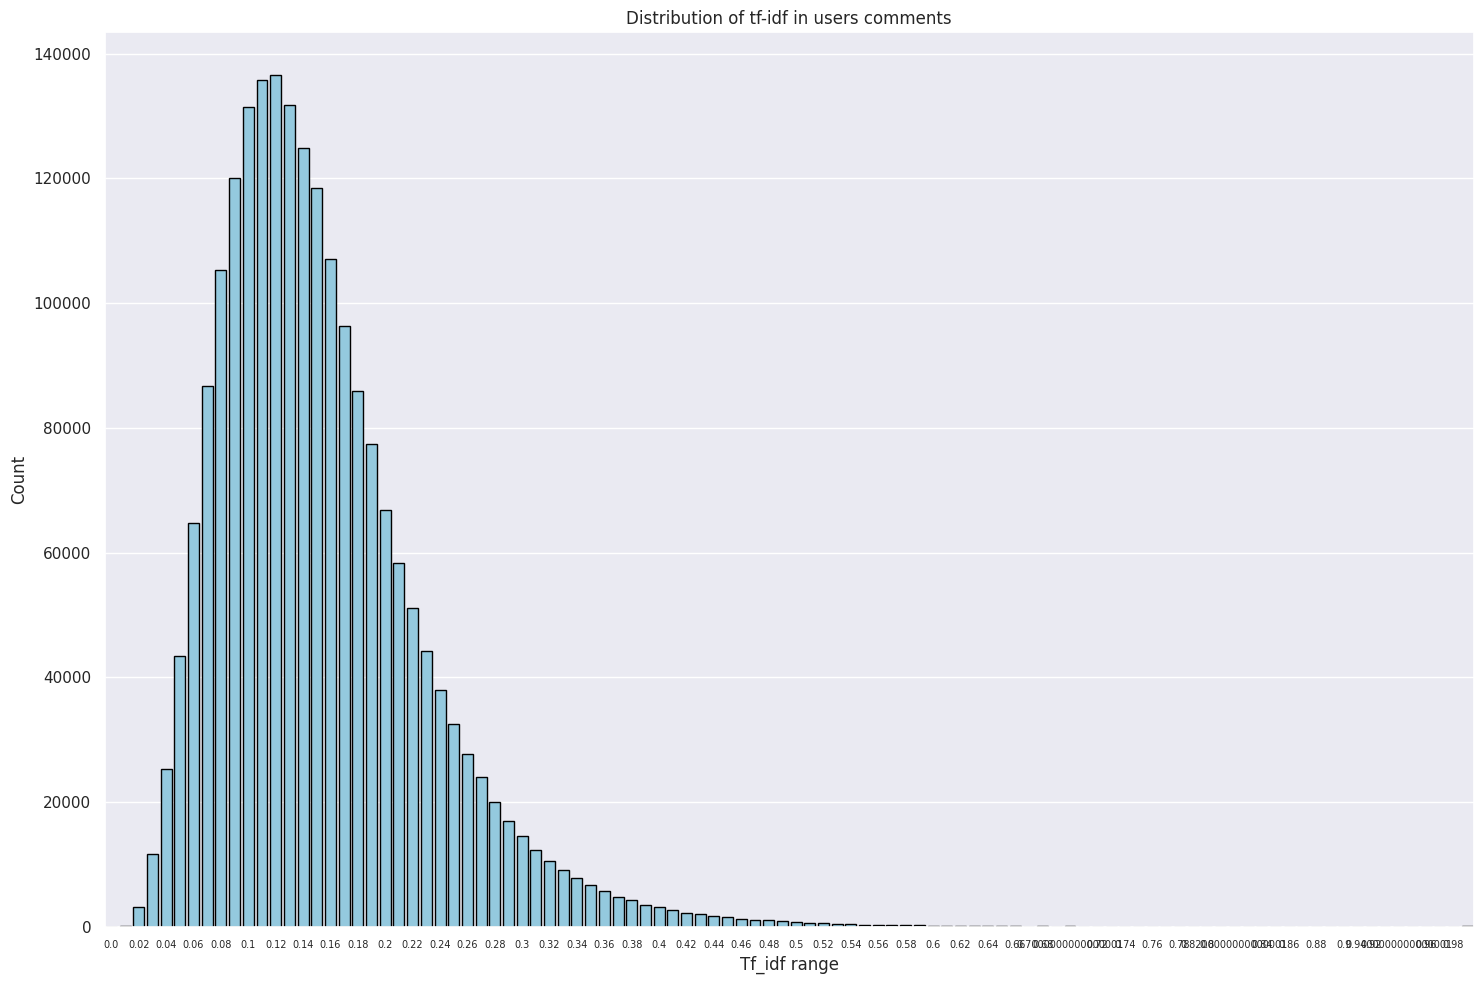

In [56]:
plt.figure(figsize=(15,10))
ax = sns.barplot(data=df_plot, x='Interval', y='Count', color='skyblue', edgecolor='black')

plt.xlabel('Tf_idf range', )
plt.ylabel('Count')
plt.title('Distribution of tf-idf in users comments')
plt.xticks(fontsize=7)        

xticks = ax.get_xticks()
xticklabels = ax.get_xticklabels()

# Turn off all labels first
for label in xticklabels:
    label.set_visible(False)

# Turn on every 5th label
for i in range(0, len(xticklabels), 2):
    xticklabels[i].set_visible(True)

plt.tight_layout()
plt.show()

In [64]:
density = [sum(counts[i:]) for i in range(len(counts))]

In [404]:
density_df = pd.DataFrame({"Count" : density, "Interv": bin_edges[:-1]})
density_df[density_df['Interv'] == 0.13]

,Count,Interv
13,1225775,0.13


<Axes: xlabel='Interv', ylabel='Count'>

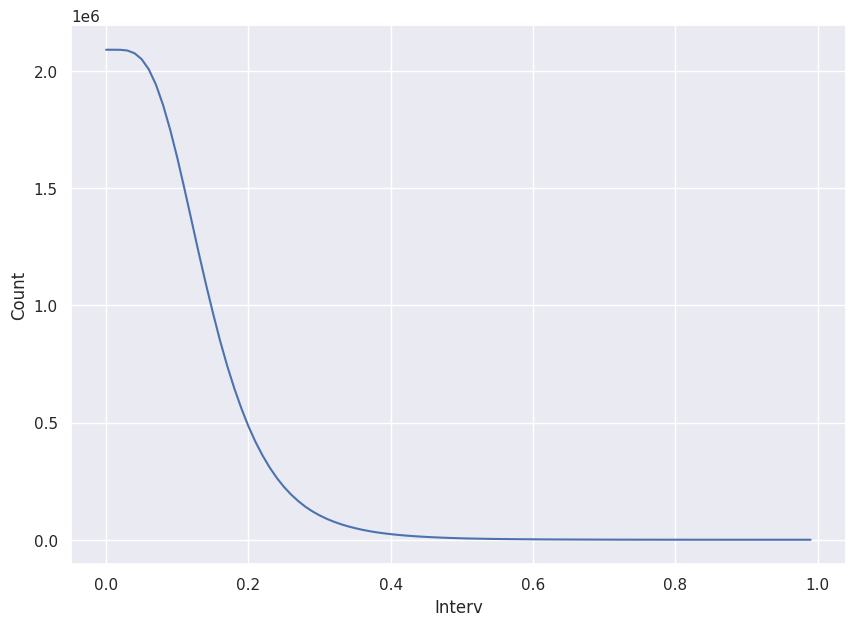

In [ ]:
plt.figure(figsize=(10,7))
sns.lineplot(density_df, x='Interv', y='Count')

In [93]:
# using tf idf filtering, count number of intersection in neg and pos
def plot_barplots(sim_users_neg, sim_users_pos, user_neg, user_pos, user_id, threshold): # user id 

        # _, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

        def f_all_comment(comment_grp): # filters the bigrams of comment using tf idf
            document = np.array([])

            for index, lem in zip(comment_grp['index'], comment_grp['Lemma']): 
                g = BigramCollocationFinder.from_words(lem.split()).score_ngrams(BigramAssocMeasures.raw_freq)
                values = vectors[index].data  # Non-zero values in the sparse matrix
                mask = values >= threshold
                values = values[mask]
                indices = vectors[index].indices[mask]
                keep_bigrams = bigrams_ens[indices[np.argsort(values)[::-1]]]
                kept = np.array([" ".join(bigram) for bigram, _ in g if " ".join(bigram) in keep_bigrams])
                if kept.size != 0:
                    document = np.concatenate((document,kept), axis = 0)
            return document        
        
        def filtered_big_df(df): # construct frequency lemma df
            bigrams_comments = df.groupby('User id').apply(f_all_comment,include_groups=False).reset_index(drop=True).values
            if bigrams_comments.size != 0:
                bigrams_comments = np.hstack(bigrams_comments)
            val, count = np.unique(bigrams_comments, return_counts=True)
            count = count/len(bigrams_comments)
            return pd.DataFrame({"Lemma": val, 'Freq': count})

        # Negatives comments
        bigrams_neg = filtered_big_df(sim_users_neg)        
        bigrams_neg_user = filtered_big_df(user_neg)

        # Find intersection
        bigrams_neg = bigrams_neg[bigrams_neg["Lemma"].isin(bigrams_neg_user["Lemma"])]
        bigrams_neg_user = bigrams_neg_user[bigrams_neg_user["Lemma"].isin(bigrams_neg["Lemma"])]

        # # Positive comments
        bigrams_pos = filtered_big_df(sim_users_pos)
        bigrams_pos_user = filtered_big_df(user_pos)
        
        # Find intersection
        bigrams_pos = bigrams_pos[bigrams_pos["Lemma"].isin(bigrams_pos_user["Lemma"])]
        bigrams_pos_user = bigrams_pos_user[bigrams_pos_user["Lemma"].isin(bigrams_pos["Lemma"])]

        # count of intersection
        assert len(bigrams_pos) == len(bigrams_pos_user)
        assert len(bigrams_neg) == len(bigrams_neg_user)

        

        # sns.barplot(data=bigrams_neg.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax1)
        # sns.barplot(data=bigrams_pos.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax2)

        # sns.barplot(data=bigrams_neg_user.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax1, color="r", alpha=0.5)
        # sns.barplot(data=bigrams_pos_user.sort_values(by="Freq", ascending=False).head(40), y="Lemma", x="Freq", ax=ax2, color="r", alpha=0.5)

        # ax1.set_title(f"Negative bigrams for user {user_id} (id)")
        # ax2.set_title(f"Positive bigrams for user {user_id} (id)")
        # ax1.tick_params(axis='y', labelsize=8)
        # ax2.tick_params(axis='y', labelsize=8)

        # plt.tight_layout()
        # return ax1, ax2
        
        return  len(bigrams_pos), len(bigrams_neg)

# type: random, simi, less_simi
def knn_comments(user_id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type = 'simi', threshold = 0, k = 40):    
    # rating matrix
    user_ind = users_table[users_table == user_id].index[0]
    games_to_hide = np.random.choice(games_to_consider, size=200, replace=False)
    hidden_games = np.intersect1d(games_table[games_table.isin(games_to_hide)].index, mask_ratings[user_ind, :].nonzero()[0])
    prev_ratings, prev_mask_ratings = matrix_ratings[user_ind, :], mask_ratings[user_ind, :], 
    prev_sim = cos_sim_matrix[user_ind, :]

    # hide games
    matrix_ratings[user_ind, hidden_games] = 0
    mask_ratings[user_ind, hidden_games] = 0

    recalc_cos_similarity(user_ind, matrix_ratings, cos_sim_matrix)

    # choice of neighbors
    match type:
        case 'simi':
            sim_users = get_KNN(cos_sim_matrix, k, user_ind)
        case 'less_simi':
            sim_users = get_KNN(cos_sim_matrix, users_table.shape[0], user_ind)[-k:] # furthest
        case 'random':
            sim_users = get_KNN(cos_sim_matrix, users_table.shape[0], user_ind) # random
            sim_users = np.random.choice(sim_users, size=k, replace=False)

    # print('number of neighbors', len(sim_users))
            
    pred_ratings, mask_pred_ratings = predict_ratings_baseline(matrix_ratings, mask_ratings,
                                                                sim_users, cos_sim_matrix, user_ind)
    
    # restore
    matrix_ratings[user_ind, :], mask_ratings[user_ind, :] = prev_ratings, prev_mask_ratings
    cos_sim_matrix[user_ind, :], cos_sim_matrix[:, user_ind] = prev_sim, prev_sim

    diff = np.abs(matrix_ratings[user_ind, hidden_games] - pred_ratings[hidden_games])

    ALLOW_ERR = 2
    user_mean = users_mean.loc[users_mean["User id"] == user_id, "Rating"].item()
    pos, neg = pred_ratings[hidden_games] < user_mean, pred_ratings[hidden_games] > user_mean

    neg_pred_games = hidden_games[np.argwhere(neg & (diff < ALLOW_ERR)).flatten()]
    pos_pred_games = hidden_games[np.argwhere(pos & (diff < ALLOW_ERR)).flatten()]

    # Find games ids
    neg_pred_games = games_table[games_table.index.isin(neg_pred_games)].values
    pos_pred_games =  games_table[games_table.index.isin(pos_pred_games)].values

    # Find users ids
    sim_users = users_table[users_table.index.isin(sim_users)].values
    sim_users_neg = comments_all[comments_all["Game id"].isin(neg_pred_games) & comments_all["User id"].isin(sim_users)]
    sim_users_pos = comments_all[comments_all["Game id"].isin(pos_pred_games) & comments_all["User id"].isin(sim_users)]
    # print(pos_pred_games)
    user_pos = comments_all[(comments_all["Game id"].isin(neg_pred_games)) & (comments_all["User id"] == user_id)]
    user_neg = comments_all[(comments_all["Game id"].isin(pos_pred_games)) & (comments_all["User id"] == user_id)]

    # print(sim_users_neg)

    # print(f"User id : {user_id}, nb correct negative : {neg_pred_games.shape[0]}, nb correct positives : {pos_pred_games.shape[0]}")
    # print(sim_users_neg.shape, sim_users_pos.shape, user_pos.shape, user_neg.shape)
    # plot_barplots(sim_users_neg, sim_users_pos, user_neg, user_pos, user_id, threshold)
    
    pos_count, neg_count = plot_barplots(sim_users_neg, sim_users_pos, user_neg, user_pos, user_id, threshold)
    return pos_count, neg_count

### 100 users, no threshold, average number of common bigrams in neg and pos reviews 

In [113]:
np.random.seed(90)
n_users = 100
users_ids_samp = comments_all.sample(n=n_users)['User id']

avg_pos_s_100 = []
avg_neg_s_100 = []
avg_pos_ls_100 = []
avg_neg_ls_100 = []
avg_pos_r_100 = []
avg_neg_r_100 = []

for id in users_ids_samp:
    # simi
    pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='simi', k=40, threshold=-1)
    avg_pos_s_100.append(pos)
    avg_neg_s_100.append(neg)

    # less_simi
    pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='less_simi', k=40, threshold=-1)
    avg_pos_ls_100.append(pos)
    avg_neg_ls_100.append(neg)

    # random
    pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='random', k=40, threshold=-1)
    avg_pos_r_100.append(pos)
    avg_neg_r_100.append(neg)

In [114]:
print(f"Average for 100 users no thresold, k=40\nSimi pos: {np.mean(avg_pos_s_100)}, neg: {np.mean(avg_neg_s_100)}\
      Less_simi pos: {np.mean(avg_pos_ls_100)}, neg: {np.mean(avg_neg_ls_100)}\
      Random pos: {np.mean(avg_pos_r_100)}, neg: {np.mean(avg_neg_r_100)}\n")

Average for 100 users no thresold, k=40
Simi pos: 34.48, neg: 32.93      Less_simi pos: 0.49, neg: 0.35      Random pos: 6.48, neg: 5.4



### 200 users no threshold

In [115]:
np.random.seed(90)
n_users = 200
users_ids_samp = comments_all.sample(n=n_users)['User id']

avg_pos_s_200 = []
avg_neg_s_200 = []
avg_pos_ls_200 = []
avg_neg_ls_200 = []
avg_pos_r_200 = []
avg_neg_r_200 = []

for id in users_ids_samp:
    # simi
    pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='simi', k=40, threshold=-1)
    avg_pos_s_200.append(pos)
    avg_neg_s_200.append(neg)

    # less_simi
    pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='less_simi', k=40, threshold=-1)
    avg_pos_ls_200.append(pos)
    avg_neg_ls_200.append(neg)

    # random
    pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='random', k=40, threshold=-1)
    avg_pos_r_200.append(pos)
    avg_neg_r_200.append(neg)

In [116]:
print(f"Average for 200 users no thresold, k=40\nSimi pos: {np.mean(avg_pos_s_200)}, neg: {np.mean(avg_neg_s_200)}\
      Less_simi pos: {np.mean(avg_pos_ls_200)}, neg: {np.mean(avg_neg_ls_200)}\
      Random pos: {np.mean(avg_pos_r_200)}, neg: {np.mean(avg_neg_r_200)}\n")

Average for 200 users no thresold, k=40
Simi pos: 34.09, neg: 34.055      Less_simi pos: 0.41, neg: 0.36      Random pos: 6.19, neg: 5.94



For 100 and 200 users there's not much difference, can choose 200 users

#### Mean on 5 evaluations, 200 users

In [425]:
n_users = 200
for _ in range(5):
    users_ids_samp = comments_all.sample(n=n_users)['User id']

    avg_pos_s_200 = []
    avg_neg_s_200 = []
    avg_pos_ls_200 = []
    avg_neg_ls_200 = []
    avg_pos_r_200 = []
    avg_neg_r_200 = []

    for id in users_ids_samp:
        # simi
        pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='simi', k=40, threshold=-1)
        avg_pos_s_200.append(pos)
        avg_neg_s_200.append(neg)

        # less_simi
        pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='less_simi', k=40, threshold=-1)
        avg_pos_ls_200.append(pos)
        avg_neg_ls_200.append(neg)

        # random
        pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='random', k=40, threshold=-1)
        avg_pos_r_200.append(pos)
        avg_neg_r_200.append(neg)
    print(f"Average for 200 users no thresold, k=40\nSimi pos: {np.mean(avg_pos_s_200)}, neg: {np.mean(avg_neg_s_200)}\
      Less_simi pos: {np.mean(avg_pos_ls_200)}, neg: {np.mean(avg_neg_ls_200)}\
      Random pos: {np.mean(avg_pos_r_200)}, neg: {np.mean(avg_neg_r_200)}\n")

/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Average for 200 users no thresold, k=40
Simi pos: 41.265, neg: 41.265      Less_simi pos: 0.365, neg: 0.315      Random pos: 8.475, neg: 8.27



/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Average for 200 users no thresold, k=40
Simi pos: 33.78, neg: 34.75      Less_simi pos: 0.385, neg: 0.39      Random pos: 6.12, neg: 5.945



/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)
/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Average for 200 users no thresold, k=40
Simi pos: 37.225, neg: 36.7      Less_simi pos: 0.44, neg: 0.505      Random pos: 7.315, neg: 6.835

Average for 200 users no thresold, k=40
Simi pos: 34.475, neg: 34.545      Less_simi pos: 0.29, neg: 0.275      Random pos: 6.68, neg: 6.15



/home/franciline/anaconda3/envs/py11/lib/python3.11/site-packages/scipy/sparse/_index.py:197: SparseEfficiencyWarning: Changing the sparsity structure of a csr_array is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Average for 200 users no thresold, k=40
Simi pos: 32.44, neg: 35.925      Less_simi pos: 0.22, neg: 0.305      Random pos: 5.99, neg: 5.125



In [426]:
print(f"Average for 200 users no thresold, k=40\nSimi pos: {np.mean(avg_pos_s_200)}, neg: {np.mean(avg_neg_s_200)}\
      Less_simi pos: {np.mean(avg_pos_ls_200)}, neg: {np.mean(avg_neg_ls_200)}\
      Random pos: {np.mean(avg_pos_r_200)}, neg: {np.mean(avg_neg_r_200)}\n")

Average for 200 users no thresold, k=40
Simi pos: 32.44, neg: 35.925      Less_simi pos: 0.22, neg: 0.305      Random pos: 5.99, neg: 5.125



In [427]:
simi = pd.DataFrame({"count" : avg_pos_s_200, "User" : "Similar","Type" : "Positive Reviews"})
random = pd.DataFrame({"count" : avg_pos_r_200, "User" : "Random","Type" : "Positive Reviews"})
less_simi = pd.DataFrame({"count" : avg_pos_ls_200, "User" : "Less Similar","Type" : "Positive Reviews"})

df_pos_neg_ntshold = pd.concat([simi, less_simi, random])

simi = pd.DataFrame({"count" : avg_neg_s_200, "User" : "Similar","Type" : "Negative Reviews"})
random = pd.DataFrame({"count" : avg_neg_r_200, "User" : "Random","Type" : "Negative Reviews"})
less_simi = pd.DataFrame({"count" : avg_neg_ls_200, "User" : "Less Similar","Type" : "Negative Reviews"})

df_pos_neg_ntshold = pd.concat([df_pos_neg_ntshold, simi, less_simi, random])
df_pos_neg_ntshold

,count,User,Type
0,3,Similar,Positive Reviews
1,98,Similar,Positive Reviews
2,99,Similar,Positive Reviews
3,0,Similar,Positive Reviews
4,61,Similar,Positive Reviews
...,...,...,...
195,0,Random,Negative Reviews
196,19,Random,Negative Reviews
197,0,Random,Negative Reviews
198,68,Random,Negative Reviews


In [428]:
group_means_not = df_pos_neg_ntshold.groupby(['User', 'Type'])['count'].mean()
group_means_reset_not = group_means_not.reset_index()
group_means_reset_not['Type'] = group_means_reset_not['Type'].replace({'Negative Reviews': 'Mean Negative Reviews','Positive Reviews': 'Mean Positive Reviews'})
user_order = ['Similar', 'Random', 'Less Similar'] 
group_means_reset_not['User'] = pd.Categorical(group_means_reset_not['User'], categories=user_order, ordered=True)
group_means_reset_not

,User,Type,count
0,Less Similar,Mean Negative Reviews,0.305
1,Less Similar,Mean Positive Reviews,0.220
2,Random,Mean Negative Reviews,5.125
3,Random,Mean Positive Reviews,5.990
4,Similar,Mean Negative Reviews,35.925
5,Similar,Mean Positive Reviews,32.440


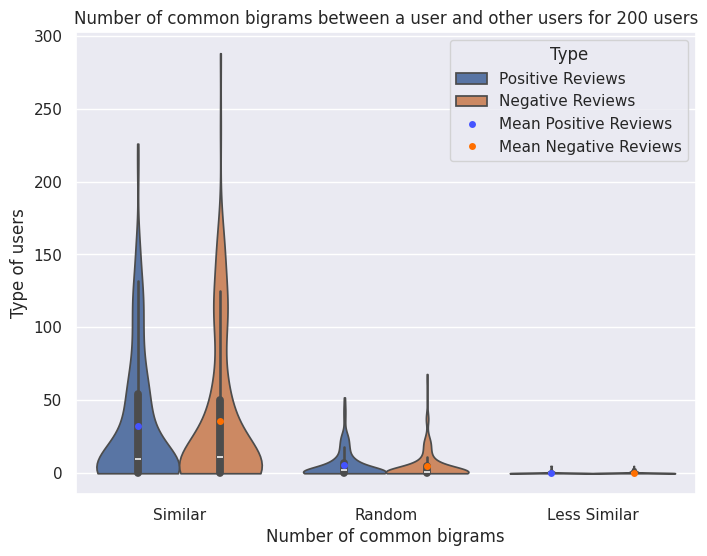

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.violinplot(data=df_pos_neg_ntshold, x="User", y="count", hue="Type",density_norm='width',order=["Similar", "Random", "Less Similar"], cut=0)
plt.xlabel("Number of common bigrams")
plt.ylabel("Type of users")
plt.title("Number of common bigrams between a user and 40 other users for 200 users")

custom_palette = {
    'Mean Positive Reviews': '#4554ff', # nuance blue  
    'Mean Negative Reviews': '#ff6f00', # nuance orange
}

sns.stripplot(
    data=group_means_reset_not,
    x='User',
    y='count',
    hue='Type',
    dodge=True,
    hue_order=['Mean Positive Reviews', 'Mean Negative Reviews'],       
    jitter=True,     
    marker='o', 
    palette=custom_palette,       
)
plt.savefig("../images/vplot_common_big_200_ntshold.png")

### With threshold = 0.13 

In [430]:
n_users = 200
for _ in range(5):
    users_ids_samp = comments_all.sample(n=n_users)['User id']

    avg_pos_s_200 = []
    avg_neg_s_200 = []
    avg_pos_ls_200 = []
    avg_neg_ls_200 = []
    avg_pos_r_200 = []
    avg_neg_r_200 = []

    for id in users_ids_samp:
        # simi
        pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='simi', k=40, threshold=0.13)
        avg_pos_s_200.append(pos)
        avg_neg_s_200.append(neg)

        # less_simi
        pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='less_simi', k=40, threshold=0.13)
        avg_pos_ls_200.append(pos)
        avg_neg_ls_200.append(neg)

        # random
        pos, neg = knn_comments(id, games_to_consider, matrix_ratings, mask_ratings, cos_sim_matrix, users_table, games_table, type='random', k=40, threshold=0.13)
        avg_pos_r_200.append(pos)
        avg_neg_r_200.append(neg)
    print(f"Average for 200 users no thresold, k=40\nSimi pos: {np.mean(avg_pos_s_200)}, neg: {np.mean(avg_neg_s_200)}\
      Less_simi pos: {np.mean(avg_pos_ls_200)}, neg: {np.mean(avg_neg_ls_200)}\
      Random pos: {np.mean(avg_pos_r_200)}, neg: {np.mean(avg_neg_r_200)}\n")
    


Average for 200 users no thresold, k=40
Simi pos: 8.545, neg: 9.735      Less_simi pos: 0.035, neg: 0.055      Random pos: 0.89, neg: 1.055

Average for 200 users no thresold, k=40
Simi pos: 9.995, neg: 11.245      Less_simi pos: 0.055, neg: 0.025      Random pos: 0.985, neg: 0.935

Average for 200 users no thresold, k=40
Simi pos: 7.635, neg: 8.475      Less_simi pos: 0.015, neg: 0.02      Random pos: 0.88, neg: 1.02

Average for 200 users no thresold, k=40
Simi pos: 9.01, neg: 9.92      Less_simi pos: 0.015, neg: 0.025      Random pos: 0.865, neg: 1.095

Average for 200 users no thresold, k=40
Simi pos: 9.615, neg: 11.66      Less_simi pos: 0.02, neg: 0.02      Random pos: 0.955, neg: 1.055



In [431]:
print(f"Average for 200 users thresold = 0.13, k=40\nSimi pos: {np.mean(avg_pos_s_200)}, neg: {np.mean(avg_neg_s_200)}\
    Less_simi pos: {np.mean(avg_pos_ls_200)}, neg: {np.mean(avg_neg_ls_200)}\
    Random pos: {np.mean(avg_pos_r_200)}, neg: {np.mean(avg_neg_r_200)}\n")

Average for 200 users thresold = 0.13, k=40
Simi pos: 9.615, neg: 11.66    Less_simi pos: 0.02, neg: 0.02    Random pos: 0.955, neg: 1.055



In [432]:
simi = pd.DataFrame({"count" : avg_pos_s_200, "User" : "Similar","Type" : "Positive Reviews"})
random = pd.DataFrame({"count" : avg_pos_r_200, "User" : "Random","Type" : "Positive Reviews"})
less_simi = pd.DataFrame({"count" : avg_pos_ls_200, "User" : "Less Similar","Type" : "Positive Reviews"})

df_pos_neg = pd.concat([simi, less_simi, random])

simi = pd.DataFrame({"count" : avg_neg_s_200, "User" : "Similar","Type" : "Negative Reviews"})
random = pd.DataFrame({"count" : avg_neg_r_200, "User" : "Random","Type" : "Negative Reviews"})
less_simi = pd.DataFrame({"count" : avg_neg_ls_200, "User" : "Less Similar","Type" : "Negative Reviews"})

df_pos_neg = pd.concat([df_pos_neg, simi, less_simi, random])
df_pos_neg

,count,User,Type
0,0,Similar,Positive Reviews
1,0,Similar,Positive Reviews
2,11,Similar,Positive Reviews
3,0,Similar,Positive Reviews
4,0,Similar,Positive Reviews
...,...,...,...
195,0,Random,Negative Reviews
196,0,Random,Negative Reviews
197,0,Random,Negative Reviews
198,0,Random,Negative Reviews


In [433]:
group_means = df_pos_neg.groupby(['User', 'Type'])['count'].mean()
group_means_reset = group_means.reset_index()
group_means_reset['Type'] = group_means_reset['Type'].replace({'Negative Reviews': 'Mean Negative Reviews','Positive Reviews': 'Mean Positive Reviews'})
user_order = ['Similar', 'Random', 'Less Similar'] 
group_means_reset['User'] = pd.Categorical(group_means_reset['User'], categories=user_order, ordered=True)
group_means_reset

,User,Type,count
0,Less Similar,Mean Negative Reviews,0.020
1,Less Similar,Mean Positive Reviews,0.020
2,Random,Mean Negative Reviews,1.055
3,Random,Mean Positive Reviews,0.955
4,Similar,Mean Negative Reviews,11.660
5,Similar,Mean Positive Reviews,9.615


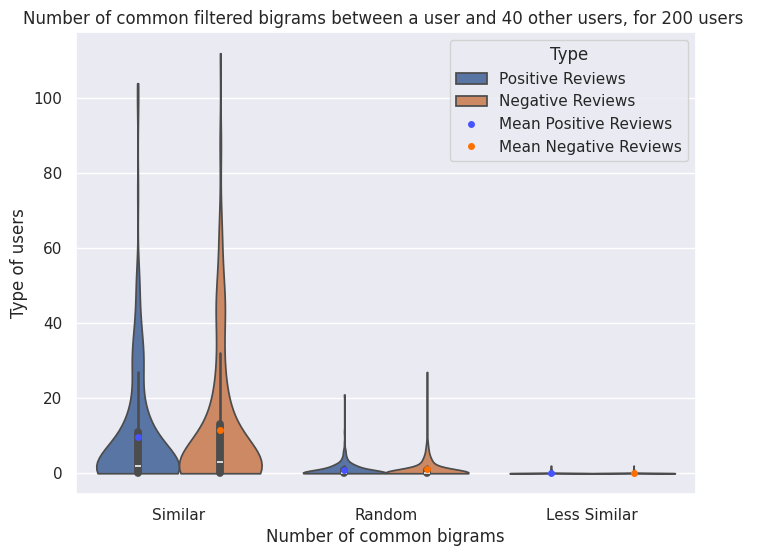

In [434]:
plt.figure(figsize=(8, 6))
ax = sns.violinplot(data=df_pos_neg, x="User", y="count", hue="Type",density_norm='width',order=["Similar", "Random", "Less Similar"], cut=0)
plt.xlabel("Number of common bigrams")
plt.ylabel("Type of users")
plt.title("Number of common filtered bigrams between a user and 40 other users, for 200 users ")

custom_palette = {
    'Mean Positive Reviews': '#4554ff', # nuance blue  
    'Mean Negative Reviews': '#ff6f00', # nuance orange
}

sns.stripplot(
    data=group_means_reset,
    x='User',
    y='count',
    hue='Type',
    dodge=True,
    hue_order=['Mean Positive Reviews', 'Mean Negative Reviews'],       
    jitter=True,     
    marker='o', 
    palette=custom_palette,       
)
plt.savefig("../images/vplot_common_big_200_0.13tshold.png")

### difference with and without threshold

In [438]:
def normal_df(data: pd.DataFrame) -> pd.DataFrame:
    # normalise the column 'count'
    df = data.copy(deep=True)
    df['count'] = (df['count'] - min(df['count'])) / (max(df['count']) - min(df['count']))
    return df

In [440]:
norm_not = normal_df(group_means_reset_not) # no threshold
norm_t = normal_df(group_means_reset)       # with threshold

In [441]:
norm_t

,User,Type,count
0,Less Similar,Mean Negative Reviews,0.000000
1,Less Similar,Mean Positive Reviews,0.000000
2,Random,Mean Negative Reviews,0.088918
3,Random,Mean Positive Reviews,0.080326
4,Similar,Mean Negative Reviews,1.000000
5,Similar,Mean Positive Reviews,0.824313


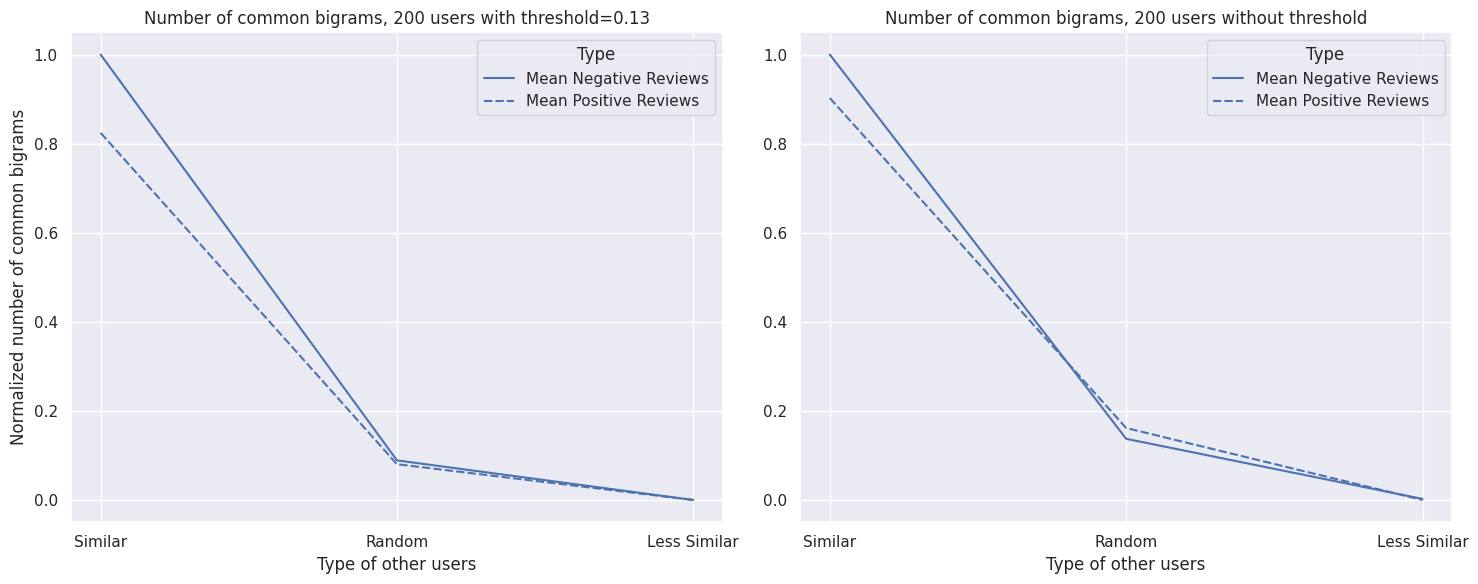

In [455]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

sns.lineplot(data=norm_t, x='User', y="count", style="Type", ax=ax[0])
ax[0].set_title("Number of common bigrams, 200 users with threshold=0.13")
ax[0].set_ylabel("Normalized number of common bigrams")
ax[0].set_xlabel("Type of other users")
sns.lineplot(data=norm_not, x='User', y="count", style="Type", ax=ax[1])
ax[1].set_title("Number of common bigrams, 200 users without threshold")
ax[1].set_ylabel("")
ax[1].set_xlabel("Type of other users")
plt.tight_layout()

plt.savefig("../images/diff_threshold_bigram_intersect.png")